In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import random
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from shutil import copyfile, rmtree

In [2]:
!ls

Baseline_Model-Copy1.ipynb              Tuberculosis-X-ray-Classification.ipynb
Baseline_Model-Copy2.ipynb              Untitled.ipynb
Baseline_Model.ipynb                    Untitled1.ipynb
README.md                               keras_tuner_dir
TB_Chest_Radiography_Database


In [3]:
!ls TB_Chest_Radiography_Database

Data_split                 README.md.txt
Normal.metadata.xlsx       Tuberculosis.metadata.xlsx


In [4]:
!ls TB_Chest_Radiography_Database/Data_split

Test       Train      Validation


In [5]:
# Instantiating a generator object and normalizing the RGB values
traingen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
testgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
valgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_data = traingen.flow_from_directory(
    directory='TB_Chest_Radiography_Database/Data_split/Train',
    target_size=(512, 512),
    class_mode='binary',
    batch_size=20,
    seed=42
)

test_data = testgen.flow_from_directory(
    directory='TB_Chest_Radiography_Database/Data_split/Test',
    target_size=(512, 512),
    class_mode='binary',
    batch_size=20,
    seed=42
)

val_data = valgen.flow_from_directory(
    directory='TB_Chest_Radiography_Database/Data_split/Validation',
    target_size=(512, 512),
    class_mode='binary',
    batch_size=20,
    seed=42
)

Found 2940 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [6]:
# Putting image classification into a dataframe.
classes = pd.DataFrame(train_data.classes)
values = classes.value_counts()

In [7]:
# Giving the data binary labels to allow for visialization of class imbalance below.
class_dict = {0:'Normal', 1:'Tuberculosis'}
classes[0] = classes[0].map(class_dict)

In [8]:
image_interpretation = classes[0].value_counts()
image_interpretation

Normal          2450
Tuberculosis     490
Name: 0, dtype: int64

In [9]:
image_interpretation.index

Index(['Normal', 'Tuberculosis'], dtype='object')

/Users/daniellerossman/Desktop/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


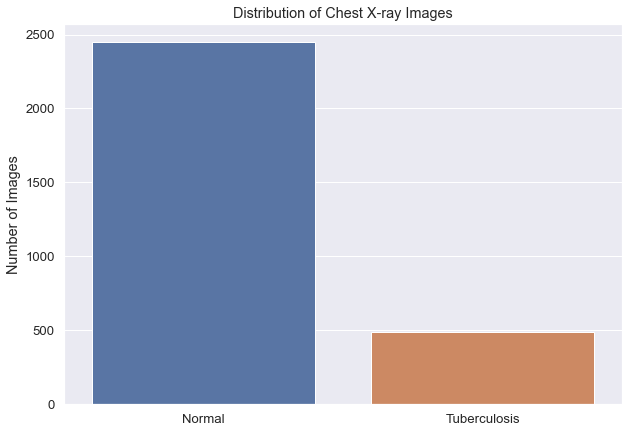

In [10]:
#Showing class imbalance, which should be corrected once I get my hands on the NIH images.
plt.figure(figsize=(10,7))
sns.set(font_scale=1.2)
sns.barplot(image_interpretation.index, image_interpretation.values)
plt.ylabel("Number of Images")
plt.title('Distribution of Chest X-ray Images');

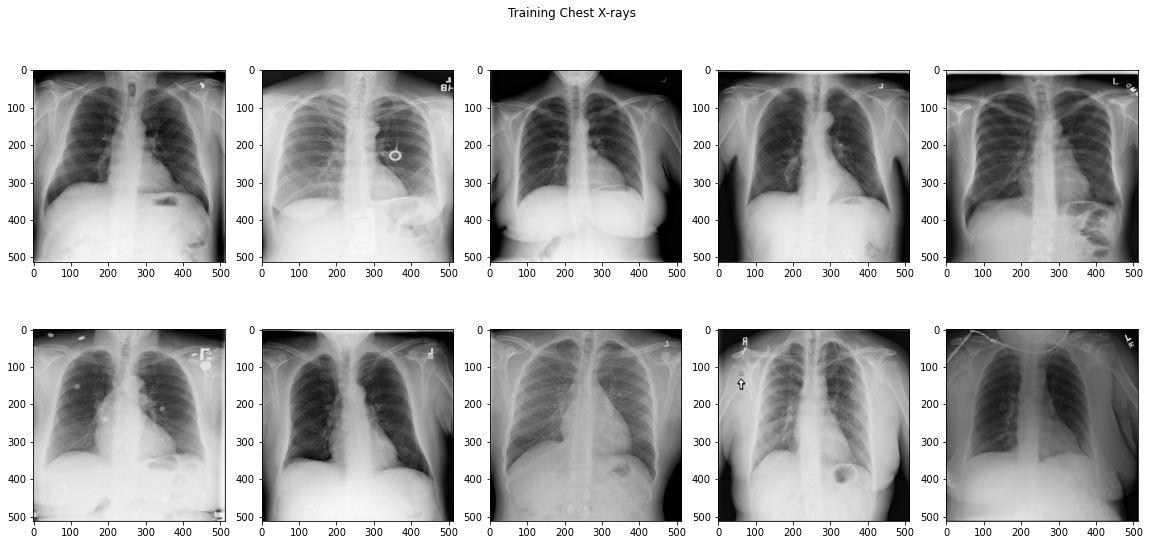

<Figure size 432x288 with 0 Axes>

In [8]:
# Visualization of 10 CXRs.
train_batch = train_data.next()
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
    
for i in range(10):
    # Load image into numpy array and re-scale
    img = np.array(train_batch[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
fig.suptitle('Training Chest X-rays')
plt.tight_layout()
plt.show()
plt.savefig('../Tuberculosis-X-ray-Classification/training_images.png')

In [12]:
input_shape = (512,512,3)

In [13]:
# Building baseline model, a multi-layer perceptron
baseline = keras.Sequential(
    [
        keras.Input(shape=input_shape), # Don't always need this input separately
        layers.Flatten(), # need to flatten our images to be one long array
        layers.Dense(64, activation="tanh"),
        layers.Dense(1, activation="sigmoid"), #sigmoid for binary
    ])

baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 786432)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                50331712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 50,331,777
Trainable params: 50,331,777
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compiling baseline model
baseline.compile(optimizer="sgd", loss="binary_crossentropy",
                 metrics=['acc', 'Recall', 'Precision'])

In [15]:
baseline_results = baseline.fit_generator(train_data,
                              steps_per_epoch=20,
                              epochs=10,
                              validation_data=test_data)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
20/20 [==============================] - 13s 631ms/step - loss: 1.3249 - acc: 0.8400 - recall: 0.0000e+00 - precision: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 336.0000 - false_positives: 0.0000e+00 - false_negatives: 64.0000 - val_loss: 1.2664 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 700.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 140.0000
Epoch 2/10
20/20 [==============================] - 13s 631ms/step - loss: 1.1042 - acc: 0.8325 - recall: 0.0000e+00 - precision: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 333.0000 - false_positives: 0.0000e+00 - false_negatives: 67.0000 - val_loss: 0.9107 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 700.0000 - val_false_positives: 0.0000e+00 - val_fa

In [17]:
# Setting up a 1st of iteration baseline MLP
baseline2 = keras.Sequential(
    [
        keras.Input(shape=(input_shape)), 
        keras.layers.Flatten(), 
        keras.layers.Dense(100, activation="tanh"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])

baseline2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 786432)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               78643300  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 78,643,401
Trainable params: 78,643,401
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling 1st iteration of MLP
baseline2.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['acc', 'Recall', 'Precision', 'TruePositives',
                               'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

In [19]:
baseline2_results = baseline2.fit_generator(train_data,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=test_data,)

Epoch 1/10
100/100 [==============================] - 39s 388ms/step - loss: 1.2997 - acc: 0.8390 - recall: 0.0063 - precision: 0.2500 - true_positives: 2.0000 - true_negatives: 1676.0000 - false_positives: 6.0000 - false_negatives: 316.0000 - val_loss: 0.6774 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 700.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 140.0000
Epoch 2/10
100/100 [==============================] - 40s 400ms/step - loss: 0.4784 - acc: 0.8360 - recall: 0.0000e+00 - precision: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 1672.0000 - false_positives: 0.0000e+00 - false_negatives: 328.0000 - val_loss: 0.4507 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 700.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 140.0000
Epoch 3/10
100/100 [==============================] - 40s 39

In [20]:
# Setting up a 1st of iteration baseline MLP
baseline2 = keras.Sequential(
    [
        keras.Input(shape=(input_shape)), 
        keras.layers.Flatten(), 
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])

baseline2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 786432)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78643300  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 78,643,401
Trainable params: 78,643,401
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compiling 1st iteration of MLP
baseline2.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['acc', 'Recall', 'Precision', 'TruePositives',
                               'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

In [22]:
baseline2_results = baseline2.fit_generator(train_data,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=test_data)

Epoch 1/10
100/100 [==============================] - 39s 392ms/step - loss: 26.0056 - acc: 0.8830 - recall: 0.6231 - precision: 0.6508 - true_positives: 205.0000 - true_negatives: 1561.0000 - false_positives: 110.0000 - false_negatives: 124.0000 - val_loss: 12.3672 - val_acc: 0.9190 - val_recall: 0.5643 - val_precision: 0.9186 - val_true_positives: 79.0000 - val_true_negatives: 693.0000 - val_false_positives: 7.0000 - val_false_negatives: 61.0000
Epoch 2/10
100/100 [==============================] - 39s 395ms/step - loss: 14.5555 - acc: 0.9145 - recall: 0.7333 - precision: 0.7446 - true_positives: 242.0000 - true_negatives: 1587.0000 - false_positives: 83.0000 - false_negatives: 88.0000 - val_loss: 15.1660 - val_acc: 0.9167 - val_recall: 0.5071 - val_precision: 0.9861 - val_true_positives: 71.0000 - val_true_negatives: 699.0000 - val_false_positives: 1.0000 - val_false_negatives: 69.0000
Epoch 3/10
100/100 [==============================] - 43s 428ms/step - loss: 6.0558 - acc: 0.9470 

In [25]:
one_hidden_dropout_layer = keras.Sequential(
    [
        keras.Input(shape=(input_shape)), 
        keras.layers.Flatten(),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation="sigmoid"),
    ])

one_hidden_dropout_layer.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 786432)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                39321650  
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 39,321,701
Trainable params: 39,321,701
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compiling the two hidden layer dropout MLP
one_hidden_dropout_layer.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['acc', 'Recall', 'Precision', 'TruePositives',
                               'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

In [ ]:
# Fitting the two hidden layer dropout MLP
one_hidden_dropout_layer_results = one_hidden_dropout_layer.fit_generator(train_data,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=test_data)


Epoch 1/10
100/100 [==============================] - 31s 310ms/step - loss: 9.3458 - acc: 0.8010 - recall: 0.0939 - precision: 0.2385 - true_positives: 31.0000 - true_negatives: 1571.0000 - false_positives: 99.0000 - false_negatives: 299.0000 - val_loss: 0.6728 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 700.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 140.0000
Epoch 2/10
100/100 [==============================] - 32s 317ms/step - loss: 0.6697 - acc: 0.8280 - recall: 0.0000e+00 - precision: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 1656.0000 - false_positives: 0.0000e+00 - false_negatives: 344.0000 - val_loss: 0.6423 - val_acc: 0.8333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 700.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 140.0000
Epoch 3/10
100/100 [==============================] - 31s 

In [ ]:
visualize_results(two_hidden_dropout_results)